# Vehicle Detection and Tracking

The goals / steps of this project are the following:

1. Decide what features to use
    * color based features
    * gradient based features
2. Choose and train a classifier. A linear SVM is probably a best bet for ideal combination of  speed and accuracy
3. Implement sliding window technique to search for vehicles in some test images
    * Multiscale search
    * Tiling schemes
4. Once we got a working detection pipeline, try it on a video stream, and implement tracking to detect vehicles.

## Feature extraction on a labeled training set of images

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
from scipy.ndimage import rotate
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label

Here we combined both color-based and shape based features. While it could be cumbersome to include three color channels of a full resolution image, we perform spatial binning on an image and still retain enough information to help in finding vehicles. We also compute color histogram features.

Color-based features only capture one aspect of object's appearance. When we have class of objects that can vary in color, gradients will give more robust representation. We compute histogram of gradient directions or orientations feature.

All the above features are combined by concatinating them. Features are normalized after concatination to avoid one type of feature dominating the other.

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0):    
    # Define an empty list to receive features
    img_features = []
    for image in imgs:
        img = mpimg.imread(image)
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(img)
        # Compute spatial features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Compute histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Compute HOG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    # Return concatenated array of features
    return img_features

In [3]:
cars, notcars = [], []

cars += (glob.glob('./dataset/vehicles/GTI_Far/*.png') +
         glob.glob('./dataset/vehicles/GTI_Left/*.png') +
         glob.glob('./dataset/vehicles/GTI_MiddleClose/*.png') +
         glob.glob('./dataset/vehicles/GTI_Right/*.png') +
         glob.glob('./dataset/vehicles/KITTI_extracted/*.png'))

notcars += (glob.glob('./dataset/non-vehicles/Extras/*.png') +
            glob.glob('./dataset/non-vehicles/GTI/*.png'))

In [4]:
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)

color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

In [5]:
car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                hist_range=hist_range, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   hist_range=hist_range, orient=orient,
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)

In [6]:
# import pdb;pdb.set_trace()
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

## Train a Linear SVM classifier 

We use the feature vectors computed above to detect cars. Design a SVM classifier that can differentiate between car images and non-car images, then run that classifier across an entire frame by sampling small patches along the way. The patches that are classified as car are the desired detections.

We train the classifier to distinguish between car and non-car images

In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

10.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


That's a great accuracy

## Mulit-scale windows

In general, we don't know what size our object of interest will be in the image we are searching. So it makes sense to search multiple scales. Here we are establishing minimum and maximum scale at which we expect the object to appear and then reasonable number of intermediate scales to scan as well

In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
start, stop, step = 90, 191, 20
xy_window = [(n, int(n * 0.65)) for n in range(start, stop, step)]
ystart = 400
overlap = 1.65
y_start_stop = [(ystart, ystart + n + 2 * step) for n in range(start, stop, step)]
xy_overlap = [(0.8, 0.8) for _ in range(start, stop, step)]

color = []
for _ in range(start, stop, step):
    base = [0, 0, 0]
    base[random.randint(0,2)] = random.randint(150, 255)
    color.append(tuple(base))

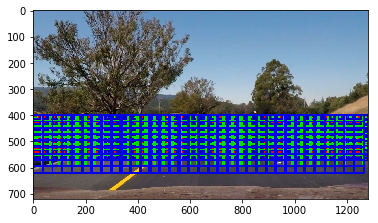

In [10]:
%matplotlib inline

image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)
image = image * 1.0 / 255

windows = []
for i in range(len(xy_window)):
    current_windows = slide_window(image, y_start_stop=y_start_stop[i], xy_window=xy_window[i], xy_overlap=xy_overlap[i])
    windows += current_windows
    draw_image = draw_boxes(draw_image, current_windows, color=color[i])

plt.imshow(draw_image)
plt.imsave('./output_images/Multi_scale_windows.jpg', draw_image)

Patches at above window locations will be searched for for in each and every frame of the test video

## Use sliding-window technique and a trained classifier to search for vehicles in images

We have restricted the search area for the cars in an image to lower half of the image as shown above. Also window sizes is chosen by taking into account that cars appear smaller near the horizon and larger when they are close to our camera.

In [11]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Compute spatial features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Compute histogram features
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Compute HOG features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))      
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append features to list
    img_features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    # Return concatenated array of features
    return img_features

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            if clf.decision_function(test_features) >= 0.9:
                on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

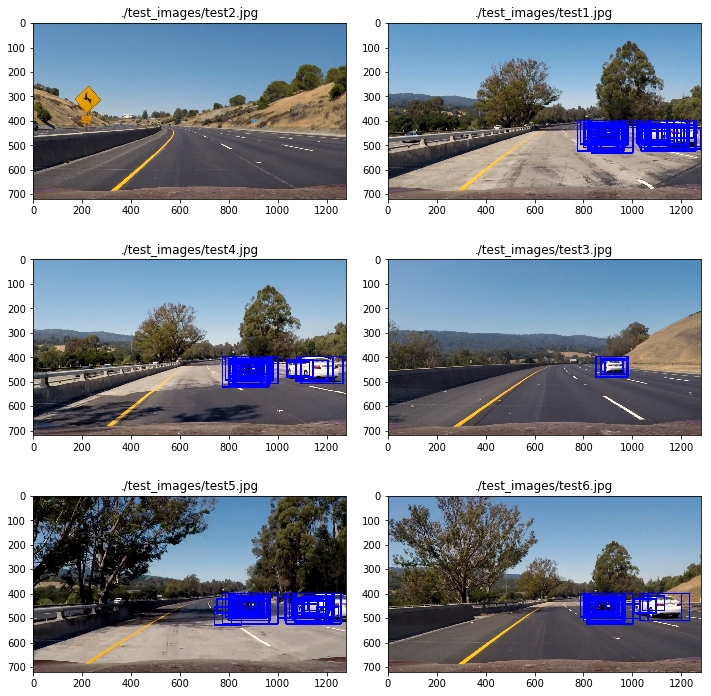

In [12]:
%matplotlib inline
f, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()
f.tight_layout()


start, stop, step = 90, 191, 20
xy_window = [(n, int(n * 0.65)) for n in range(start, stop, step)]
ystart = 400
overlap = 1.65
y_start_stop = [(ystart, ystart + n + 2 * step) for n in range(start, stop, step)]
xy_overlap = [(0.8, 0.8) for _ in range(start, stop, step)]

images = glob.glob('./test_images/*.jpg')
for j, file in enumerate(images):
    image = mpimg.imread(file)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    windows = []
    for i in range(len(xy_window)):
        # windows += slide_window(image, y_start_stop=y_start_stop[i], xy_window=xy_window[i], xy_overlap=xy_overlap[i])
        windows += slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], xy_window=xy_window[i], xy_overlap=xy_overlap[i])

    car_windows = search_windows(image, windows, svc, X_scaler, color_space='HLS', 
                             spatial_size=spatial_size, hist_bins=hist_bins, 
                             hist_range=hist_range, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                             hog_channel=hog_channel)
    draw_image = draw_boxes(draw_image, car_windows)
    axs[j].imshow(draw_image)
    axs[j].set_title(file)

f.savefig('./output_images/Sliding_window_SVM_classify.jpg')

Results seems to be pretty good, but there is a false positive in test2.jpg, and there are many duplicate detections in rest of the images.
Following section removes false positives and multiple detections

## Heat map to remove false positives and multiple detections

To make a heat-map, you're simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by your classifier. The "hot" parts of the map are where the cars are, and by imposing a threshold, we can reject areas affected by false positives. 

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Following output shows the averaged detections after getting rid of false positives and mulitple detections.

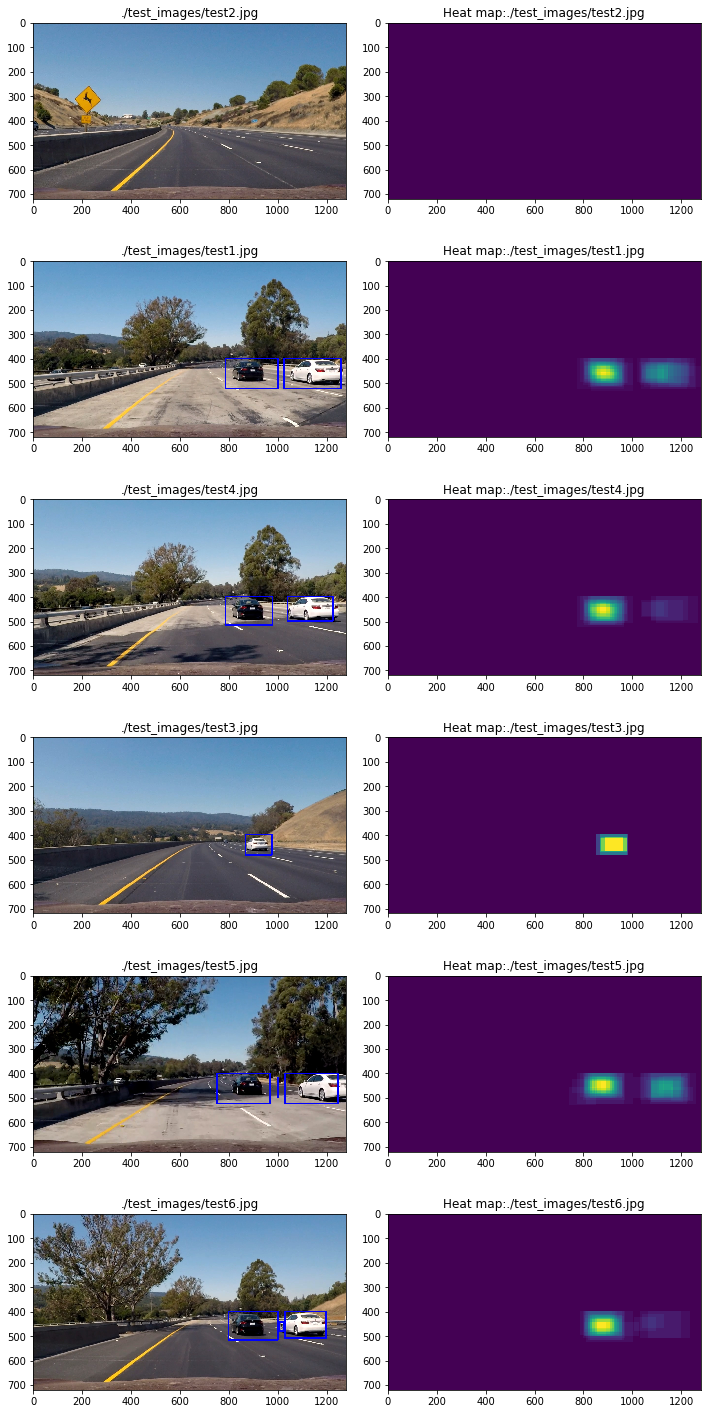

In [14]:
f, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.ravel()
f.tight_layout()

start, stop, step = 90, 191, 20
xy_window = [(n, int(n * 0.65)) for n in range(start, stop, step)]
ystart = 400
overlap = 1.65
y_start_stop = [(ystart, ystart + n + 2 * step) for n in range(start, stop, step)]
xy_overlap = [(0.8, 0.8) for _ in range(start, stop, step)]

images = glob.glob('./test_images/*.jpg')
for j, file in enumerate(images):
    image = mpimg.imread(file)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    windows = []
    for i in range(len(xy_window)):
        windows += slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], xy_window=xy_window[i], xy_overlap=xy_overlap[i])

    car_windows = search_windows(image, windows, svc, X_scaler, color_space='HLS', 
                             spatial_size=spatial_size, hist_bins=hist_bins, 
                             hist_range=hist_range, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                             hog_channel=hog_channel)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, car_windows)
    axs[2*j + 1].imshow(heat)
    axs[2*j + 1].set_title('Heat map:' + file)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    axs[2*j].imshow(draw_img)
    axs[2*j].set_title(file)

f.savefig('./output_images/Centroid_window_heatmap.jpg')

That's pretty cool ! We were able to detect all the cars without and false positives and multiple detections

## Run above pipeline on a video stream

In practice, we integrated a heat map over several frames of video, such that areas of multiple detections get "hot", while transient false positives stay "cool". we then simply thresholded the heatmap to remove false positives.

Once you have a thresholded heat-map, there are many ways we could go about trying to figure out how many cars you have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the label() function from scipy.ndimage.measurements.

In [15]:
start, stop, step = 90, 191, 20
xy_window = [(n, int(n * 0.65)) for n in range(start, stop, step)]
ystart = 400
overlap = 1.65
y_start_stop = [(ystart, ystart + n + 2 * step) for n in range(start, stop, step)]
xy_overlap = [(0.8, 0.8) for _ in range(start, stop, step)]

class Heat():
    def __init__(self, length = 4):
        self.length = length
        self.heat_history = deque(maxlen=length)
        self.heat_history_full = False
    
    def queue_heat(self, heat):
        self.heat_history.appendleft(heat)
        self.heat_history_full = len(self.heat_history) == self.length

def process_image(image):

    draw_image = np.copy(image)
    
    combined = pipeline(image)
    warped = warp_image(combined, mtx, dist, M)
    lane_pixels(warped, left_lane, right_lane)

    if np.max(image) > 1:
        image = image.astype(np.float32)/255

    windows = []
    for i in range(len(xy_window)):
        windows += slide_window(image, x_start_stop=[700, 1260], y_start_stop=y_start_stop[i], xy_window=xy_window[i], xy_overlap=xy_overlap[i])

    car_windows = search_windows(image, windows, svc, X_scaler, color_space='HLS', 
                             spatial_size=spatial_size, hist_bins=hist_bins, 
                             hist_range=hist_range, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                             hog_channel=hog_channel)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, car_windows)
    
    heatobj.queue_heat(heat)
    
    if heatobj.heat_history_full == True:
        heat_avg = np.mean(heatobj.heat_history, axis=0)
    else:
        heat_avg = heat
    
    heat = apply_threshold(heat_avg, 2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    draw_image = draw_lines(warped, draw_image, left_lane,right_lane)
    draw_image = draw_labeled_bboxes(draw_image, labels)
    
    return draw_image

## Advanced Lane detections

We have integrated the code from project 4 (Adavnced Lane Detection) to find lanes as well as vehicles in the currect video stream. Many following cells include Lane detection code.

In [16]:
def get_obj_img_points(nx=9, ny=6):
    # prepare object points, like (0,0,0),
    # (1,0,0),..,(8,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points
    # from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search
    # for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray,
                                                 (nx, ny),
                                                 None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints

# obtain camera calibration parameters

def cal_camera(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                                    objpoints,
                                    imgpoints,
                                    gray.shape[::-1],
                                    None,
                                    None)
    return mtx, dist

# undistort the image

def cal_undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [17]:
# function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x',
                     sobelksize=9,
                     sobelx_thresh=(10, 255),
                     sobely_thresh=(60, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel2thresh = {'x': sobelx_thresh,
                    'y': sobely_thresh}
    if orient == 'x':
        abs_sobel = np.absolute(
                        cv2.Sobel(gray,
                                  cv2.CV_64F,
                                  1, 0,
                                  ksize=sobelksize))
    if orient == 'y':
        abs_sobel = np.absolute(
                        cv2.Sobel(gray,
                                  cv2.CV_64F,
                                  0, 1,
                                  ksize=sobelksize))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    l_thresh = sobel2thresh[orient][0]
    h_thresh = sobel2thresh[orient][1]
    binary_output[(scaled_sobel >= l_thresh) &
                  (scaled_sobel <= h_thresh)] = 1

    return binary_output

# function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobelksize=9, m_thresh=(30, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,
                       ksize=sobelksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,
                       ksize=sobelksize)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= m_thresh[0]) &
                  (gradmag <= m_thresh[1])] = 1

    return binary_output
    
# function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobelksize=9,
                  dir_thresh=(0.65, 1.05)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,
                       ksize=sobelksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,
                       ksize=sobelksize)
    absgraddir = np.arctan2(np.absolute(sobely),
                            np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) &
                  (absgraddir <= dir_thresh[1])] = 1

    return binary_output

# H and S channel, and color thresholds
def hls_select(img, channel='s',
               h_thresh=(50, 150),
               s_thresh=(150, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls2channel = {'h': 0, 's': 2}
    hls2thresh = {'h': h_thresh, 's': s_thresh}
    c_channel = hls[:,:,hls2channel[channel]]
    binary_output = np.zeros_like(c_channel)
    l_thresh = hls2thresh[channel][0]
    r_thresh = hls2thresh[channel][1]
    binary_output[(c_channel > l_thresh) &
                  (c_channel <= r_thresh)] = 1
    return binary_output

# select a region of interest in the image to
# accurately determine the lanes
def region_of_interest(img, vertices):
    # defining a blank mask to start with
    mask = np.zeros_like(img)   

    # defining a 3 channel or 1 channel color to
    # fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # filling pixels inside the polygon defined by
    # "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def pipeline(img, gblurrksize=5):
    
    image = cv2.GaussianBlur(img, 
                             (gblurrksize,
                              gblurrksize),
                             0)

    binary_x = abs_sobel_thresh(image, orient='x')
    binary_y = abs_sobel_thresh(image, orient='y')
    
    mag_binary = mag_thresh(image)
    
    dir_binary = dir_threshold(image)
    
    binary_h = hls_select(image, channel='h')
    binary_s = hls_select(image, channel='s')
    
    combined = np.zeros_like(dir_binary)
    
    # selection for pixels where both the x and y
    # gradients meet the threshold criteria, or
    # the gradient magnitude and direction are 
    # both within their threshold values, or
    # selection for pixels where both the h and s
    # color channel meet the threshold criteria
    combined[((binary_x == 1) & (binary_y == 1)) |
             ((mag_binary == 1) & (dir_binary == 1)) |
             ((binary_h == 1) & (binary_s == 1))] = 1
    
    height = image.shape[0]
    width = image.shape[1]
    
    vertices = np.array([[(150, height-50),
                          (560, 450),
                          (760, 450),
                          (width-150, height-50)]],
                        dtype=np.int32)
    
    # Apply the mask
    combined = region_of_interest(combined, vertices)
    
    return combined

In [18]:
def get_PTmatrix(x, y):

    src = np.float32([[(x/2 - 150, y/2 + 100),
                       (x/2 + 150, y/2 + 100),
                       (x - 50,    y - 40),
                       (100,       y - 40)]])
    dst = np.float32([[(0,      0),
                       (x - 50, 0),
                       (x - 50, y),
                       (100,    y)]])

    return (cv2.getPerspectiveTransform(src, dst),
            cv2.getPerspectiveTransform(dst, src))

def corners_unwarp(undist, M, img_size):
    return cv2.warpPerspective(undist,
                               M,
                               img_size,
                               flags=cv2.INTER_LINEAR)

# warp the thresholded image so that we can fit second order
# polynomial to find road lanes
def warp_image(image, mtx, dist, M):
    # undistort
    undist = cal_undistort(image, mtx, dist)
    img_size = (image.shape[1], image.shape[0])
    # warp image
    return corners_unwarp(undist, M, img_size)

In [19]:
#Define Line class as suggested in the lecture

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        self.fit_history = deque(maxlen=6)
        self.fit_history_full = False

def radius_of_curvature(ploty, fitx):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    y_eval = np.mean(ploty)
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = (((1 +
                 (2*fit_cr[0]*y_eval*ym_per_pix +
                  fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0]))
    return curverad


# Locate the Lane Lines and Fit a Polynomial
def lane_detections(curv, lane, fit):
    lane.detected = True if ((lane.detected and abs(curv/lane.radius_of_curvature - 1) < 0.10) or
                             (lane.radius_of_curvature and abs(curv/lane.radius_of_curvature - 1) < 0.20) or
                             (not lane.detected and not lane.radius_of_curvature)) else False

    if lane.detected:
        lane.current_fit = fit
        lane.radius_of_curvature = curv
        lane.fit_history.appendleft(fit)
        lane.fit_history_full = len(lane.fit_history) == 6

# Line Finding Method: Peaks in a Histogram and Sliding Window
# Implement Sliding Windows and Fit a Polynomial
# With this histogram I am adding up the pixel values along
# each column in the image. In my thresholded binary image,
# pixels are either 0 or 1, so the two most prominent peaks
# in this histogram will be good indicators of the x-position
# of the base of the lane lines.
def lane_pixels(image, left_lane, right_lane):
    nwindows = 9
    margin = 100
    minpix = 50
    img = np.copy(image)
    
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if (left_lane.detected == False or
        right_lane.detected == False): 
        # Find the peak of the left and right halves of
        # the histogram. These will be the starting point
        # for the left and right lines
        
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Set height of windows
        
        window_height = np.int(img.shape[0]/nwindows)
        
        # Current positions to be updated for each window
        
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive
        # left and right lane pixel indices
        
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        
        for window in range(nwindows):
            
            # Identify window boundaries in x and y
            # (and right and left)
            
            win_y_low = (img.shape[0] -
                        (window+1)*window_height)
            win_y_high = (img.shape[0] -
                          window*window_height)
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Identify the nonzero pixels in x and y
            # within the window
            
            good_left_inds = ((nonzeroy >= win_y_low) &
                              (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) &
                              (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) &
                               (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) &
                               (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter
            # next window on their mean position

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(
                                    nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(
                                    nonzerox[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    # Skip the sliding windows step once you know where the lines are
    else:
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) +
                                       left_fit[1]*nonzeroy +
                                       left_fit[2] -
                                       margin)) &
                          (nonzerox < (left_fit[0]*(nonzeroy**2) +
                                       left_fit[1]*nonzeroy +
                                       left_fit[2] +
                                       margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) +
                                        right_fit[1]*nonzeroy +
                                        right_fit[2] -
                                        margin)) &
                           (nonzerox < (right_fit[0]*(nonzeroy**2) +
                                        right_fit[1]*nonzeroy +
                                        right_fit[2] +
                                        margin)))

    # Extract left and right line pixel positions
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Measuring Curvature
    left_fitx = (left_fit[0]*ploty**2 +
                 left_fit[1]*ploty +
                 left_fit[2])
    right_fitx = (right_fit[0]*ploty**2 +
                  right_fit[1]*ploty +
                  right_fit[2])

    left_curvature = radius_of_curvature(ploty, left_fitx)
    right_curvature = radius_of_curvature(ploty, right_fitx)
    
    lane_detections(left_curvature, left_lane, left_fit)
    lane_detections(right_curvature, right_lane, right_fit)
    
    return

In [20]:
def car_position(image, left_fitx, right_fitx):
    xm_per_pix = 3.7/700
    center = image.shape[1]/2
    image_center = (left_fitx[-40] + right_fitx[-40])/2
    return (center - image_center) * xm_per_pix

def draw_lines(warped, image, left_lane, right_lane):
    if (left_lane.fit_history_full == True and
        right_lane.fit_history_full == True):
        left_fit = np.mean(left_lane.fit_history,axis=0)
        right_fit = np.mean(right_lane.fit_history,axis=0)
    else:   
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit

    ploty = np.linspace(0, warped.shape[0]-1,
                        warped.shape[0])
    left_fitx = (left_fit[0]*ploty**2 +
                 left_fit[1]*ploty +
                 left_fit[2])
    right_fitx = (right_fit[0]*ploty**2 +
                  right_fit[1]*ploty +
                  right_fit[2])

    # Create an image to draw the lines on
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero,
                            warp_zero,
                            warp_zero))
    
    # Recast the x and y points into usable
    # format for cv2.fillPoly()
    
    pts_left = np.array([np.transpose(
                            np.vstack([left_fitx,
                                       ploty]))])
    pts_right = np.array([np.flipud(
                            np.transpose(
                                np.vstack([right_fitx,
                                           ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
     
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space
    # using inverse perspective matrix (Minv)
    
    img_size = (image.shape[1], image.shape[0])
    newwarp = cv2.warpPerspective(color_warp,
                                  Minv,
                                  img_size)
    
    # Combine the result with the original image
    undist = cal_undistort(image, mtx, dist)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #Put text on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius = int((left_lane.radius_of_curvature +
                  right_lane.radius_of_curvature) / 2)
    text = "Radius of Curvature:{} m".format(radius)
    cv2.putText(result, text, (200,60), font, 1,
                (255,255,255),2)
    
    # Find the position of the car
    
    position = car_position(image, left_fitx, right_fitx)

    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result, text, (200,100), font, 1, (255,255,255), 2)
    
    return result

def mark_lane(image):
    
    combined = pipeline(image)
    warped = warp_image(combined, mtx, dist, M)
    lane_pixels(warped, left_lane, right_lane)
    result = draw_lines(warped, image, left_lane,right_lane)
    
    return result

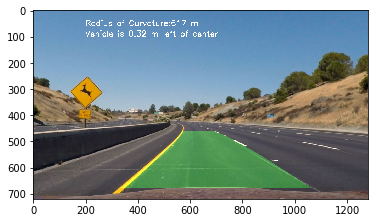

In [21]:
image = cv2.imread('test_images/test{}.jpg'.format(2))

objpoints, imgpoints = get_obj_img_points()
mtx, dist = cal_camera(image, objpoints, imgpoints)
M, Minv = get_PTmatrix(image.shape[1], image.shape[0])

left_lane = Line()
right_lane = Line()

marked_image = mark_lane(image)
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))

### Finally, detect lanes and vehicles in a video frame

In [22]:
left_lane = Line()
right_lane = Line()
heatobj = Heat()

vc = VideoFileClip('./project_video.mp4')
mi = vc.fl_image(process_image)
mi.write_videofile('./project_video_output.mp4', audio=False);

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [45:57<00:02,  2.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

